<a href="https://colab.research.google.com/github/hallpaz/3dsystems23/blob/main/assignments/lab7_loading3Dmodels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3D Graphics Systems | AI Graphics - Theory and Practice | IMPA 2023
### Instructor: Luiz Velho
### TA: Hallison Paz
### Course info: https://lvelho.impa.br/i3d23/

## Lab Class #7 - Loading and Visualizing 3D Data

# Part 1 - Read and elaborate

1.1 Read the paper [ShapeNet: An Information-Rich 3D Model Repository](https://arxiv.org/abs/1512.03012). What can you say about the importance and the challenges of building a large dataset for 3D machine learning?


*Use this space to write your thoughts*

# Part 2 - Learn

2.0 Run the following cells and read the explanations. It's an opportunity to get some familiarization with PyTorch3D. In "part 3" you are going to run some experiments.

In [ ]:
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith(("1.13.", "2.0.")) and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61429 sha256=0b72fe65900342a3f0d276b7dfd7ff3e6985d94fc1346edbc8fb54e563b0fd36
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31547 sha256=272b6f0ee21d9acfc231481caababc2224659a24de6704e71f529df574075294
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built fvcore iopath
Looking in links: https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/py310_cu118_pyt200/dow

In [ ]:
import numpy as np
import torch

from pytorch3d.datasets import (
    R2N2,
    ShapeNetCore,
    collate_batched_meshes,
    render_cubified_voxels,
)
from pytorch3d.renderer import (
    FoVPerspectiveCameras,
    PointLights,
    RasterizationSettings,
    TexturesVertex,
    look_at_view_transform,
)

from pytorch3d.structures import Meshes
from torch.utils.data import DataLoader

# add path for demo utils functions 
import sys
import os
sys.path.append(os.path.abspath(''))

In [ ]:
import matplotlib.pyplot as plt

If using **Google Colab**, fetch the utils file for plotting image grids and the ShapeNet JSON files to map corresponding ids and categories:

In [ ]:
!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/master/docs/tutorials/utils/plot_image_grid.py

!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/master/pytorch3d/datasets/shapenet/shapenet_synset_dict_v1.json
!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/master/pytorch3d/datasets/shapenet/shapenet_synset_dict_v2.json
!cp /content/shapenet_synset_dict_v1.json  /usr/local/lib/python3.6/dist-packages/pytorch3d/datasets/shapenet/shapenet_synset_dict_v1.json
!cp /content/shapenet_synset_dict_v2.json  /usr/local/lib/python3.6/dist-packages/pytorch3d/datasets/shapenet/shapenet_synset_dict_v2.json

from plot_image_grid import image_grid

--2023-05-09 00:17:56--  https://raw.githubusercontent.com/facebookresearch/pytorch3d/master/docs/tutorials/utils/plot_image_grid.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1608 (1.6K) [text/plain]
Saving to: ‘plot_image_grid.py’

plot_image_grid.py  100%[===================>]   1.57K  --.-KB/s    in 0s      

2023-05-09 00:17:57 (33.4 MB/s) - ‘plot_image_grid.py’ saved [1608/1608]

--2023-05-09 00:17:57--  https://raw.githubusercontent.com/facebookresearch/pytorch3d/master/pytorch3d/datasets/shapenet/shapenet_synset_dict_v1.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.

OR if running locally uncomment and run the following cell:

In [ ]:
# from utils import image_grid

# 2.1. Load the datasets

We'll work on a small subset of the ShapeNetCore version 2 dataset. 

The whole dataset has more than 25GB and can be downloaded following the instructions here: https://www.shapenet.org/. Check the instructions page for the .zip file with our selected small subset of ShapeNet. If you are running on Google Colab, we suggest you upload the uncompressed folders to you Google Drive account and access its path here.

After downloading the data, modify `SHAPENET_PATH` below to you local path to the ShapeNetCore dataset folder. 

In [ ]:
# Setup
if torch.cuda.is_available():
 device = torch.device("cuda:0")
 torch.cuda.set_device(device)
else:
 device = torch.device("cpu")

SHAPENET_PATH = ""
shapenet_dataset = ShapeNetCore(SHAPENET_PATH,version=2)

/usr/local/lib/python3.10/dist-packages/pytorch3d/datasets/shapenet/shapenet_core.py:114: UserWarning: The following categories are included in ShapeNetCore ver.2's official mapping but not found in the dataset location /content/drive/MyDrive/s3d21/SNCorev2: 03797390, 02942699, 03790512, 02801938, 03642806, 04256520, 04099429, 03593526, 04468005, 02828884, 02924116, 04379243, 03759954, 03085013, 02880940, 03991062, 02954340, 03001627, 02808440, 02773838, 03207941, 03636649, 03325088, 03467517, 02843684, 02958343, 04530566, 03046257, 02818832, 03948459, 04090263, 03928116, 04330267, 03761084, 04004475, 03261776, 02992529, 02933112, 02876657, 03211117, 03337140, 04460130, 02691156, 02871439, 03938244, 02946921, 03691459, 04225987, 03513137, 04401088, 03624134, 02747177
  warnings.warn(msg)


We can retrieve a model by indexing into the loaded dataset. We can examine the category this model belongs to (in the form of a synset id, equivalent to wnid described in ImageNet's API: http://image-net.org/download-API), its model id, and its vertices and faces.

In [ ]:
shapenet_model = shapenet_dataset[1]
print("This model belongs to the category " + shapenet_model["synset_id"] + ".")
print("This model has model id " + shapenet_model["model_id"] + ".")
model_verts, model_faces = shapenet_model["verts"], shapenet_model["faces"]

This model belongs to the category 04074963.
This model has model id 8e167ac56b1a437017d17fdfb5740281.


We can use its vertices and faces to form a `Meshes` object which is a PyTorch3D datastructure for working with batched meshes.

In [ ]:
model_textures = TexturesVertex(verts_features=torch.ones_like(model_verts, device=device)[None])
shapenet_model_mesh = Meshes(
    verts=[model_verts.to(device)],   
    faces=[model_faces.to(device)],
    textures=model_textures
)

## 2.2. Render ShapeNetCore models with PyTorch3D's differentiable renderer

The `ShapeNetCore` dataloader has a customized `render` function that support rendering models by specifying their model ids, categories or indices using PyTorch3D's differentiable renderer implementation.

In [ ]:
# Rendering settings.
R, T = look_at_view_transform(1.0, 1.0, 90)
cameras = FoVPerspectiveCameras(R=R, T=T, device=device)
raster_settings = RasterizationSettings(image_size=512)
lights = PointLights(location=torch.tensor([0.0, 1.0, -2.0], 
                                           device=device)[None],device=device)

First we will try to render three models by their model ids:

/usr/local/lib/python3.10/dist-packages/pytorch3d/io/mtl_io.py:102: UserWarning: Texture UV coordinates outside the range [0, 1].                 The integer part will be ignored to form a repeating pattern.
  warnings.warn(msg)


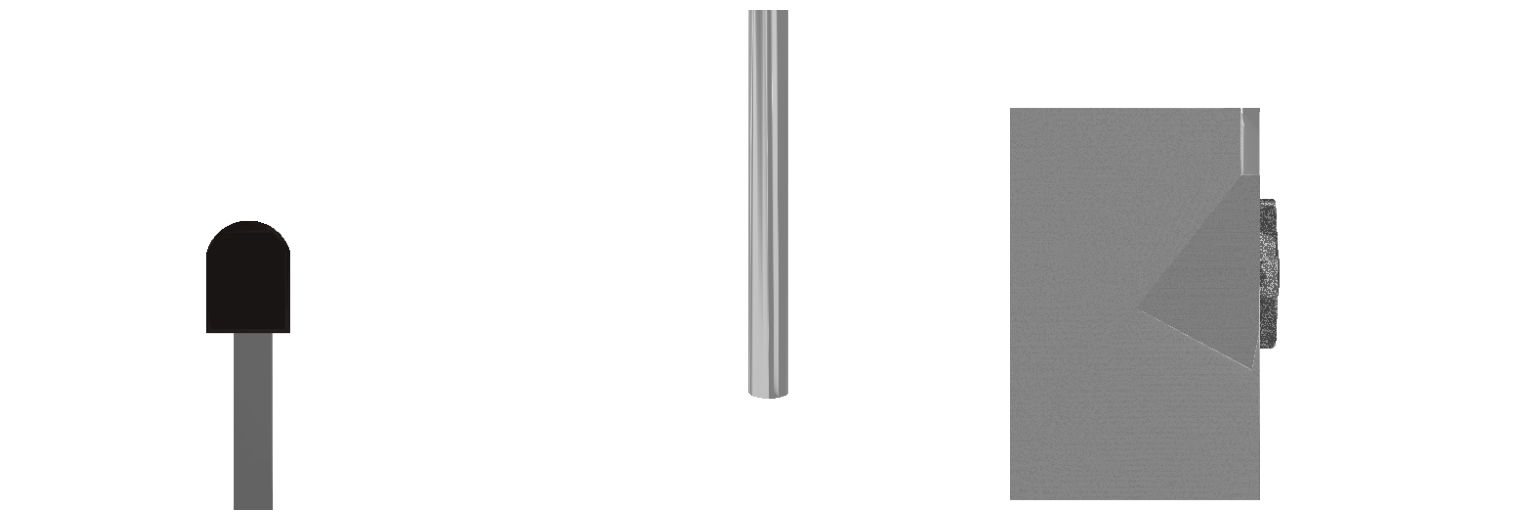

In [ ]:
images_by_model_ids = shapenet_dataset.render(
    model_ids=[
        "1e4df43ee2f2da6967f9cc18b363cf72",
        "6f6ed9e0d29b64e714be24585075d395",
        "da0179a5b68f13586a6a687121d74e50"
    ],
    device=device,
    cameras=cameras,
    raster_settings=raster_settings,
    lights=lights,
)
image_grid(images_by_model_ids.cpu().numpy(), rows=1, cols=3, rgb=True)

We can also render models by their indices. For instance, if we would like to render the three models at indices 93, 109 and 200:

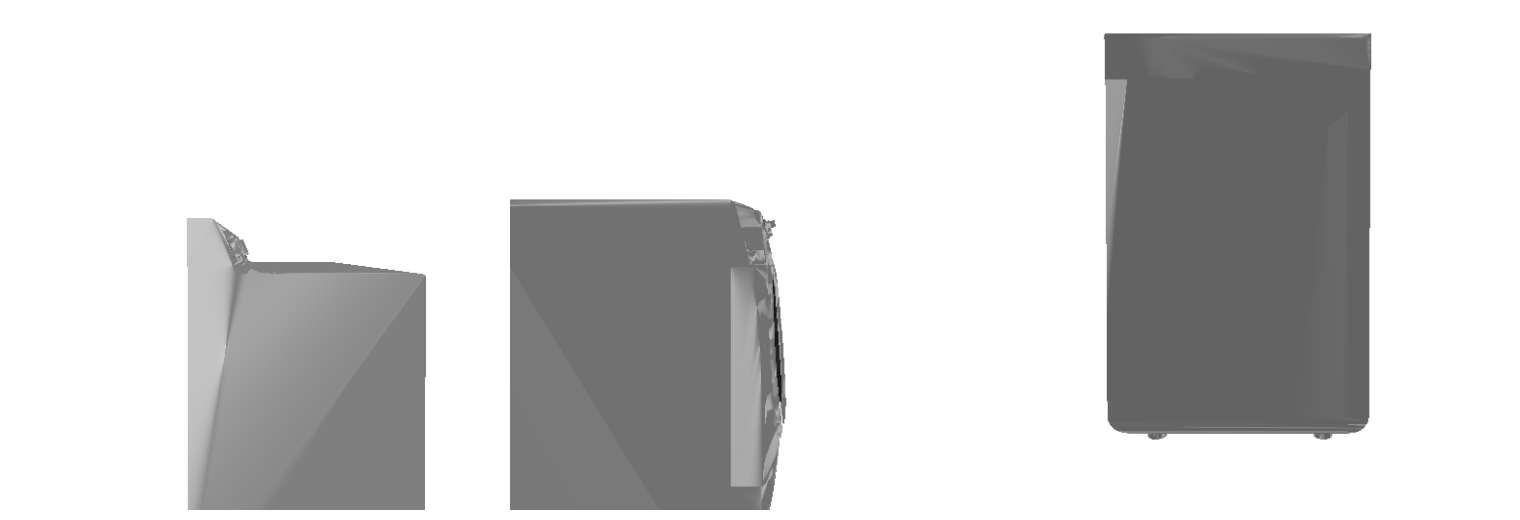

In [ ]:
images_by_idxs = shapenet_dataset.render(
    idxs=[93, 109, 200],
    device=device,
    cameras=cameras,
    raster_settings=raster_settings,
    lights=lights,
)
image_grid(images_by_idxs.cpu().numpy(), rows=1, cols=3, rgb=True)

Alternatively, if we are not interested in any particular models but would like see random models from some specific categories, we can do that by specifying `categories` and `sample_nums`. For example, if we would like to render 2 models from the category "mailbox" and 3 models from the category "washer", we can do the following:

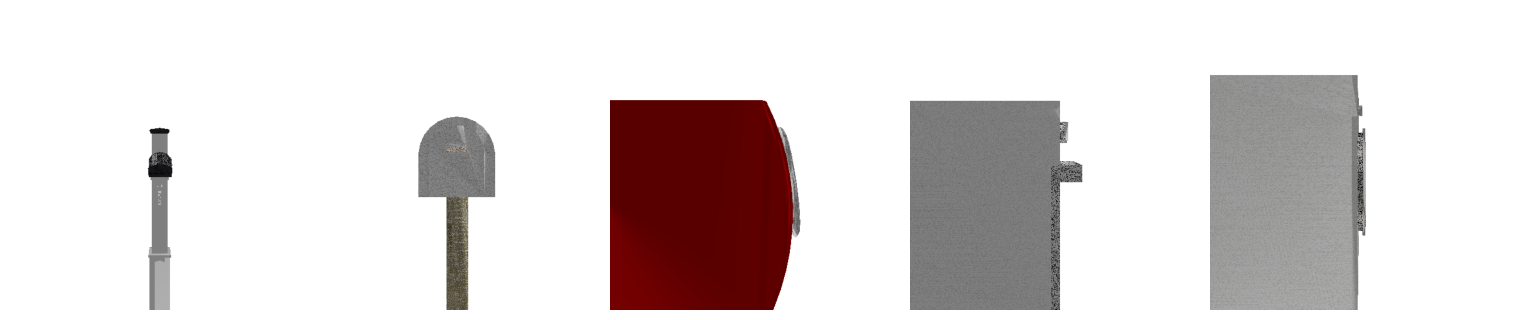

In [ ]:
# we also have the category "remote" in this subset of ShapeNet
images_by_categories = shapenet_dataset.render(
    categories=["mailbox", "washer"],
    sample_nums=[2, 3],
    device=device,
    cameras=cameras,
    raster_settings=raster_settings,
    lights=lights,
)
image_grid(images_by_categories.cpu().numpy(), rows=1, cols=5, rgb=True)

If we are not interested in any particular categories and just would like to render some random models from the whole dataset, we can set the number of models to be rendered in `sample_nums` and not specify any `categories`:

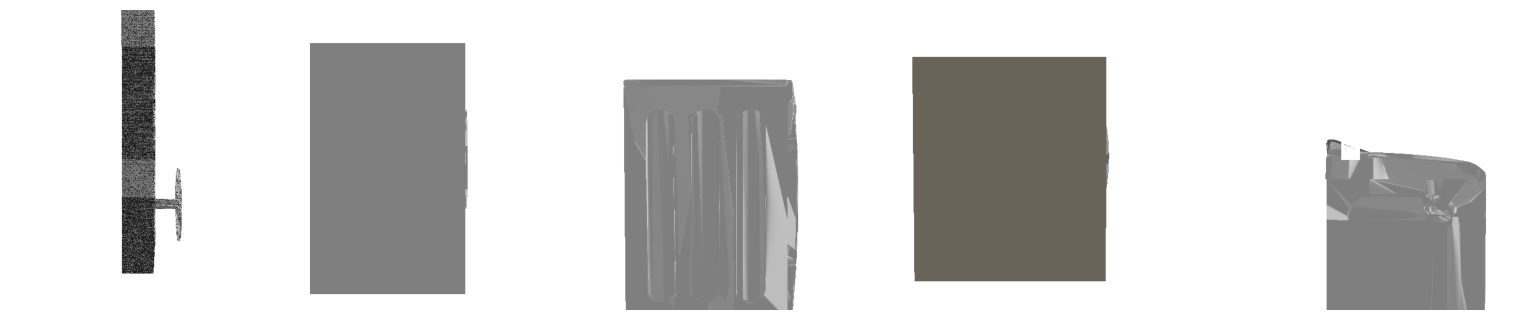

In [ ]:
random_model_images = shapenet_dataset.render(
    sample_nums=[5],
    device=device,
    cameras=cameras,
    raster_settings=raster_settings,
    lights=lights,
)
image_grid(random_model_images.cpu().numpy(), rows=1, cols=5, rgb=True)

# Part 3 - Plotly Visualization

PyTorch3D has a differentiable renderer which allows us to generate images and take derivatives of the images with respect to the scene parameters. A differentiable renderer is very powerful, but it more computing intensive and it requires some setup. 

In this assignment, we only want to visualize the meshes, so we'll use Ploty for that. 

In [ ]:
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib

3.0. Show the number of instances in our subset of the ShapeNet dataset using the function `len` on `shapenet_dataset`

3.1. Create a Meshes object by taking it's vertices and faces from a shapenet model. Name your variable `myfirstmesh` so the code on the cell below display correctly.


In [ ]:
##############################################################################
# Code for 3.0-3.1.
##############################################################################

In [ ]:
# Render the plotly figure
fig = plot_scene({
    "subplot1": {
        "shapenet_mesh": myfirstmesh
    }
})
fig.show()

As You just saw, the function `plot_scene` takes a dictionary of subplots and returns a plotly figure. Each subplot is a dictionary of kind `name: mesh`. 

3.2. You can render textured models using Ploty. Create a Meshes object passing `verts`, `faces` and `textures` arguments. `textures` must be a `TexturesVertex` object. It's not an easy task to create a `TextureVertex` directly from the ShapeNet model, so for now we suggest you create a simple tensor like a noisy color or other kind of pattern you can control. 

3.3. Create another Meshes object from ShapeNet and show both models in the same subplot. 
  
  **Extra - E.1: you can create a batch of Meshes instead of two or more individual Meshes objects. To do so, note that the arguments to build a Meshes instance are, in fact, lists.**


3.4. Each mesh is represented in its own coordinate system. This way, when you put them in the same subplot, they will overlap. This time, create a new subplot and plot the meshes. 

  **Extra - E.2: if you created a batch of Meshes, use the function** `plot_batch_individually`.


3.5. Experiment changing the figure size using `fig.update_layout(height:int,width:int)` . Experiment adding the arguments below to the `plot_scene` or `plot_batch_individually` functions.
```
  (...)
  xaxis={"backgroundcolor":"rgb(200, 200, 230)"},
  yaxis={"backgroundcolor":"rgb(230, 200, 200)"},
  zaxis={"backgroundcolor":"rgb(200, 230, 200)"},
  axis_args=AxisArgs(showgrid=True)
  (...)
  ```
  **Extra - E.3: Create a `Meshes` instance by computing vertices and faces of a parametric model and visualize it.**

In [ ]:
##############################################################################
# Code for 3.2-3.5 (and extras).
##############################################################################

# Part 4 - Exploring new data

Recently, the Allen Institute for AI released a [dataset called Objaverse](https://objaverse.allenai.org) with 800K+ annotated 3D objects. You may want to check their webpage where you can find a [paper](https://arxiv.org/abs/2212.08051) and a [Google Colab](https://colab.research.google.com/drive/1ZLA4QufsiI_RuNlamKqV7D7mn40FbWoY?usp=sharing) showing how the dataset is structured, and demonstrating how to use it.

4.1 Load a couple of 3D objects from the Objaverse dataset as PyTorch3D Meshes and visualize them using PyTorch3D's differentiable renderer. You may need to adjust the camera's or the object's pose for a better visualization. 

*Note: You will need to enable GLB file format loading as [demonstrated in this file](https://github.com/facebookresearch/pytorch3d/blob/main/pytorch3d/io/experimental_gltf_io.py).*


4.2  Now, we want to use the Plotly visualizer to render the objects. Check the `textures` attribute of your `meshes` reference. It's probably a `TexturesUV` instance. As we have learned, Plotly can only render `TexturesVertex` instances. Use the function `convert_to_textureVertex` below to generate a `TexturesVertex` instance and use it as the `textures` attribute of your meshes. Finally, render your meshes using the Plotly backend.



In [ ]:
def convert_to_textureVertex(textures_uv: TexturesUV, meshes:Meshes) -> TexturesVertex:
    verts_colors_packed = torch.zeros_like(meshes.verts_packed())
    verts_colors_packed[meshes.faces_packed()] = textures_uv.faces_verts_textures_packed()
    return TexturesVertex(packed_to_list(verts_colors_packed, meshes.num_verts_per_mesh()))

In [ ]:
##############################################################################
# Code for 4.1-4.2
##############################################################################